In [ ]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

21834768/21834768 [==============================] - 0s 0us/step


In [ ]:

import tensorflow as tf
train_directory = "/content/drive/MyDrive/caers/train"
val_directory = "/content/drive/MyDrive/caers/test"
ds_train= tf.keras.utils.image_dataset_from_directory(
  train_directory,
  seed=123,
  image_size=(224, 224),
  batch_size=32)
ds_test = tf.keras.utils.image_dataset_from_directory(
  val_directory,
  seed=123,
  image_size=(224, 224),
  batch_size=32)
class_names = ds_train.class_names
print(class_names)
class_names_2 = ds_test.class_names


Found 1400 files belonging to 7 classes.
Found 672 files belonging to 7 classes.
['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [ ]:
def input_preprocess(image, label):
    label = tf.one_hot(label, 7)
    return image, label
batch_size = 64

ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


In [ ]:
print(ds_train)


<_PrefetchDataset element_spec=(TensorSpec(shape=(64, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64, None, 7), dtype=tf.float32, name=None))>


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
from tensorflow.keras import layers

IMG_SIZE=224
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


Not connected to a TPU runtime. Using CPU/GPU strategy


In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)
size = (IMG_SIZE, IMG_SIZE)
#ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
#ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))
print(ds_train)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/25
44/44 - 366s - loss: 2.4421 - accuracy: 0.4207 - val_loss: 1.8848 - val_accuracy: 0.4122 - 366s/epoch - 8s/step
Epoch 2/25
44/44 - 199s - loss: 1.7175 - accuracy: 0.5693 - val_loss: 1.6133 - val_accuracy: 0.4598 - 199s/epoch - 5s/step
Epoch 3/25
44/44 - 194s - loss: 1.6914 - accuracy: 0.5829 - val_loss: 1.6587 - val_accuracy: 0.5551 - 194s/epoch - 4s/step
Epoch 4/25
44/44 - 221s - loss: 1.5549 - accuracy: 0.6114 - val_loss: 1.5391 - val_accuracy: 0.5744 - 221s/epoch - 5s/step
Epoch 5/25
44/44 - 220s - loss: 1.4631 - accuracy: 0.6321 - val_loss: 1.6272 - val_accuracy: 0.5848 - 220s/epoch - 5s/step
Epoch 6/25
44/44 - 215s - loss: 1.4615 - accuracy: 0.6379 - val_loss: 1.7395 - val_accuracy: 0.5640 - 215s/epoch - 5s/step
Epoch 7/25
44/44 - 193s - loss: 1.3920 - accuracy: 0.6607 - val_loss: 1.7360 - val_accuracy: 0.5833 - 193s/epoch - 4s/step
Epoch 8/25
44/44 - 219s - loss: 1.2924 - accuracy: 0.6643 - val_loss: 2.11

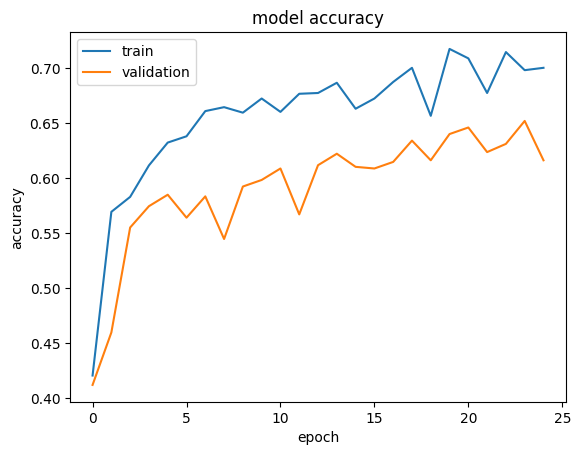

In [ ]:
with strategy.scope():
    model = build_model(num_classes=7)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)


1/1 [==============================] - 2s 2s/step
[[0.525      0.046875   0.04210526 0.         0.025      0.
  0.        ]
 [0.10625    0.5546875  0.03157895 0.07042254 0.         0.
  0.        ]
 [0.00625    0.078125   0.71578947 0.08450704 0.0125     0.03076923
  0.10958904]
 [0.075      0.0703125  0.08421053 0.6056338  0.1125     0.01538462
  0.19178082]
 [0.11875    0.09375    0.02105263 0.15492958 0.5875     0.03076923
  0.04109589]
 [0.09375    0.0625     0.03157895 0.05633803 0.1125     0.84615385
  0.02739726]
 [0.075      0.09375    0.07368421 0.02816901 0.15       0.07692308
  0.63013699]]


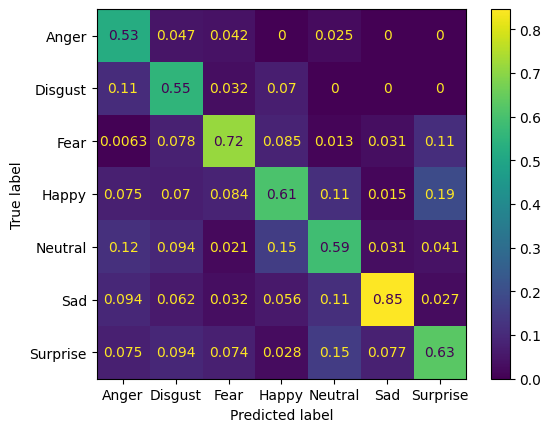

In [ ]:
import numpy as np
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in ds_test:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

from sklearn.metrics import confusion_matrix
result = confusion_matrix(correct_labels, predicted_labels , normalize='pred')
print(result)

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

cm_display.plot()
plt.show()

Epoch 1/10
44/44 - 250s - loss: 0.8437 - accuracy: 0.7343 - val_loss: 1.4641 - val_accuracy: 0.6711 - 250s/epoch - 6s/step
Epoch 2/10
44/44 - 229s - loss: 0.7134 - accuracy: 0.7679 - val_loss: 1.4905 - val_accuracy: 0.6786 - 229s/epoch - 5s/step
Epoch 3/10
44/44 - 227s - loss: 0.6552 - accuracy: 0.7643 - val_loss: 1.4598 - val_accuracy: 0.6949 - 227s/epoch - 5s/step
Epoch 4/10
44/44 - 230s - loss: 0.6135 - accuracy: 0.7986 - val_loss: 1.5104 - val_accuracy: 0.6994 - 230s/epoch - 5s/step
Epoch 5/10
44/44 - 228s - loss: 0.5781 - accuracy: 0.8143 - val_loss: 1.4694 - val_accuracy: 0.7098 - 228s/epoch - 5s/step
Epoch 6/10
44/44 - 226s - loss: 0.5368 - accuracy: 0.8121 - val_loss: 1.3906 - val_accuracy: 0.7202 - 226s/epoch - 5s/step
Epoch 7/10
44/44 - 225s - loss: 0.5426 - accuracy: 0.8236 - val_loss: 1.3120 - val_accuracy: 0.7202 - 225s/epoch - 5s/step
Epoch 8/10
44/44 - 195s - loss: 0.4790 - accuracy: 0.8336 - val_loss: 1.2694 - val_accuracy: 0.7351 - 195s/epoch - 4s/step
Epoch 9/10
44/44

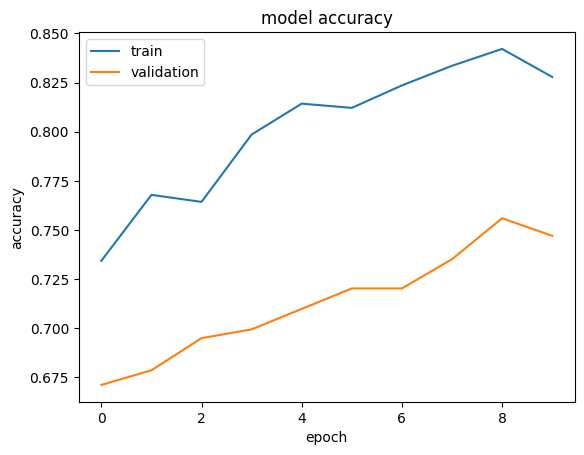

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    outputs = layers.Dense(7, activation="softmax", name="pred")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist2 = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist2)

1/1 [==============================] - 2s 2s/step
[[0.65625    0.02352941 0.03296703 0.         0.02564103 0.
  0.05      ]
 [0.1328125  0.81176471 0.03296703 0.0619469  0.         0.
  0.        ]
 [0.         0.         0.8021978  0.0619469  0.05128205 0.
  0.12      ]
 [0.03125    0.         0.03296703 0.7079646  0.06410256 0.01298701
  0.03      ]
 [0.1015625  0.05882353 0.01098901 0.14159292 0.73076923 0.01298701
  0.03      ]
 [0.0234375  0.04705882 0.04395604 0.02654867 0.07692308 0.8961039
  0.07      ]
 [0.0546875  0.05882353 0.04395604 0.         0.05128205 0.07792208
  0.7       ]]


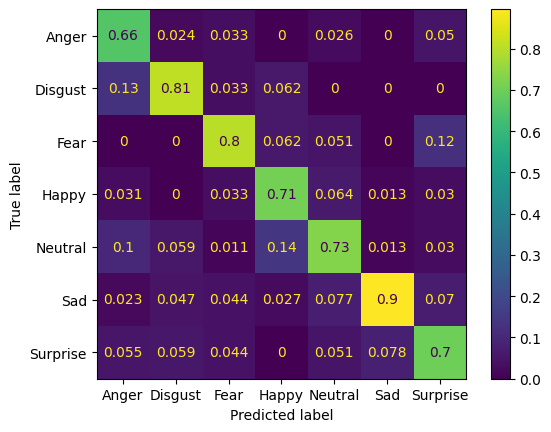

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in ds_test:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

from sklearn.metrics import confusion_matrix
result = confusion_matrix(correct_labels, predicted_labels , normalize='pred')
print(result)
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

cm_display.plot()
plt.show()